In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

from pathlib import Path
import pandas as pd
import numpy as np

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, DataFrame, Row, Window
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

import statsmodels.api as sm
import scipy.stats as stats

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from synapse.ml.lightgbm import *

pio.renderers.default = "iframe"

In [34]:
# base_path = "/data/saturation/central_composite_design/ccd6"
# base_path_holdout = "/data/saturation/central_composite_design/ccd6_holdout_larger"

base_path = "/data/saturation/central_composite_design/ccd9"
base_path_holdout = "/data/saturation/central_composite_design/ccd9_holdout"

ivs = ["slope", "min_rim_percentage", "effective_radius_multiplier", "n_craters_in_study_region", "z", "za", "areal_density"]

In [35]:
sample_size = 5000

train_df = pd.read_csv(f"{base_path}/sample_{sample_size}.csv")
train_df["za"] = train_df.za.fillna(0)
train_df["z"] = train_df.z.fillna(0)
train_df["information_lost"] = (1 - train_df.n_craters_in_study_region / train_df.n_craters_added_in_study_region).fillna(0)

# First test_df contains simulations that are near the vertices of the CCD
# Second test_df contains simulations that are in the midpoints of CCD levels
test_dfs = [
    pd.read_csv(f"{base_path}/in_sample_holdout_sample_{sample_size}.csv"),
    pd.read_csv(f"{base_path_holdout}/sample_{sample_size}.csv")
]

for test_df in test_dfs:
    test_df["za"] = test_df.za.fillna(0)
    test_df["z"] = test_df.z.fillna(0)
    test_df["information_lost"] = (1 - test_df.n_craters_in_study_region / test_df.n_craters_added_in_study_region).fillna(0)

metric = "information_lost"

In [4]:
n_cores = 28

spark = SparkSession.builder \
                    .master(f"local[{n_cores}]") \
                    .appName("Saturation") \
                    .config("spark.driver.memory", "48g") \
                    .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.10.2") \
                    .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
                    .getOrCreate()
sc = spark.sparkContext

23/06/13 16:47:08 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.86.20 instead (on interface enp8s0)
23/06/13 16:47:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


https://mmlspark.azureedge.net/maven added as a remote repository with the name: repo-1
Ivy Default Cache set to: /home/mason/.ivy2/cache
The jars for the packages stored in: /home/mason/.ivy2/jars
com.microsoft.azure#synapseml_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-e504a693-5d50-4ea6-9e2c-c61cca928754;1.0
	confs: [default]


:: loading settings :: url = jar:file:/home/mason/code/saturation/venv/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found com.microsoft.azure#synapseml_2.12;0.10.2 in central
	found com.microsoft.azure#synapseml-core_2.12;0.10.2 in central
	found org.scalactic#scalactic_2.12;3.2.14 in central
	found org.scala-lang#scala-reflect;2.12.15 in central
	found io.spray#spray-json_2.12;1.3.5 in central
	found com.jcraft#jsch;0.1.54 in central
	found org.apache.httpcomponents.client5#httpclient5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5-h2;5.1.3 in central
	found org.slf4j#slf4j-api;1.7.25 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpmime;4.5.13 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found commons-logging#commons-logging;1.2 in central
	found com.linkedin.isolation-forest#isolation-forest_3.2.0_2.12;2.0.8 in central
	found com.chuusai#shapeless_2.12;2.3.2 in central
	found

23/06/13 16:47:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### LightGBM models

#### Baseline Model

In [9]:
def score_model(model,
                df: pd.DataFrame,
                metric: str,
                assembler: VectorAssembler,
                ivs: List[str],
                features: List[str],
                sample_cadence: int = 1):
    sampled = df.iloc[[x * sample_cadence for x in range(df.shape[0] // sample_cadence)]].copy()
    y = sampled[metric]
    
    X = poly_transform.transform(sampled[ivs])
    X = pd.DataFrame(X, columns=poly_transform.get_feature_names_out())
    
    df_spark = spark.createDataFrame(X)
    spark_X = assembler.transform(df_spark)[["features"]]
    predictions = model.transform(spark_X).toPandas()["prediction"]

    pred_df = pd.concat([X, predictions], axis=1)
    pred_df["actual"] = y.reset_index(drop=True)
    pred_df["n_craters"] = list(sampled.index)
    
    return pred_df


def plot_sim_ci(model,
                df: pd.DataFrame,
                metric: str,
                assembler: VectorAssembler,
                ivs: List[str],
                features: List[str],
                sample_cadence: int = 250):   
    # Show params
    print(f"Simulation parameters: {df[ivs].iloc[0]}")
    
    ns_max = 100000
    plt.plot(df.n_craters_added_in_study_region.iloc[:ns_max],
             df[metric].iloc[:ns_max])
    plt.xlabel("$N_S$")
    plt.ylabel("$A_d$")
    plt.show()

    pred_df = score_model(model, df, metric, assembler, ivs, features, sample_cadence)
   
    fig = go.Figure()
    fig.add_scatter(x=pred_df["n_craters"],
                    y=pred_df["actual"],
                    mode="lines",
                    name="Actual")
    fig.add_scatter(x=pred_df["n_craters"],
                    y=pred_df["prediction"],
                    mode="lines",
                    name="95% Threshold")

    fig.update_layout(
        xaxis_title="$N_S$",
        yaxis_title=metric
    )

    fig.show()

In [ ]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=ivs,
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"]

model = (LightGBMRegressor()
    .setObjective('quantile')
    .setLabelCol(metric)
    .setAlpha(0.5)
    .setLearningRate(0.1)
    .setNumIterations(5)
    .setNumLeaves(5)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df.actual < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df.actual < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(ivs, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

In [ ]:
# More iterations

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=ivs,
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"]

model = (LightGBMRegressor()
    .setObjective('quantile')
    .setLabelCol(metric)
    .setAlpha(0.5)
    .setLearningRate(0.3)
    .setNumIterations(100)
    .setNumLeaves(5)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df.actual < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df.actual < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(ivs, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

In [36]:
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=3, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"]

model = (LightGBMRegressor()
    .setObjective('quantile')
    .setAlpha(0.5)
    .setLabelCol(metric)
    .setLearningRate(0.1)
    .setLambdaL2(0.1)
    .setNumIterations(1000)
    .setNumLeaves(127)
    .setMaxDepth(5)
    .setNumThreads(n_cores)
    .setParallelism("data_parallel")
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df.actual < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df.actual < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(poly_transform.get_feature_names_out(), model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

23/06/13 18:13:25 WARN TaskSetManager: Stage 85 contains a task of very large size (36832 KiB). The maximum recommended task size is 1000 KiB.


23/06/13 18:13:29 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 85 (TID 2164): Attempting to kill Python Worker
23/06/13 18:13:29 WARN TaskSetManager: Stage 86 contains a task of very large size (36832 KiB). The maximum recommended task size is 1000 KiB.


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines


23/06/13 18:18:15 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/06/13 18:18:15 WARN TaskSetManager: Stage 87 contains a task of very large size (36526 KiB). The maximum recommended task size is 1000 KiB.


Training % outside of range: 0.500
23/06/13 18:21:19 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/06/13 18:21:19 WARN TaskSetManager: Stage 88 contains a task of very large size (22561 KiB). The maximum recommended task size is 1000 KiB.


Testing % outside of range: 0.512
Feature importances:
   min_rim_percentage effective_radius_multiplier areal_density: 1700.0
   effective_radius_multiplier^2 areal_density: 1638.0
   slope: 1542.0
   effective_radius_multiplier: 1386.0
   effective_radius_multiplier^2 n_craters_in_study_region: 1270.0
   min_rim_percentage effective_radius_multiplier n_craters_in_study_region: 1084.0
   min_rim_percentage: 1072.0
   min_rim_percentage effective_radius_multiplier^2: 629.0
   slope min_rim_percentage: 615.0
   slope^2 min_rim_percentage: 593.0
   min_rim_percentage effective_radius_multiplier: 578.0
   min_rim_percentage^2 n_craters_in_study_region: 577.0
   min_rim_percentage^2 areal_density: 539.0
   slope^2 effective_radius_multiplier: 509.0
   slope min_rim_percentage areal_density: 493.0
   slope min_rim_percentage effective_radius_multiplier: 473.0
   slope^2 areal_density: 469.0
   slope effective_radius_multiplier: 467.0
   slope effective_radius_multiplier^2: 445.0
   min_rim_

### Plotting thresholds

In [38]:
def read_simulation_parquet(path: Path, sample_cadence: int) -> pd.DataFrame:
    df = pd.read_parquet(path, columns=ivs + ["simulation_id", "n_craters_added_in_study_region"])
    df = df.iloc[[x * sample_cadence for x in range(df.shape[0] // sample_cadence)]].copy()
    df["z"] = df.z.fillna(0)
    df["za"] = df.za.fillna(0)
    df["information_lost"] = (1 - df.n_craters_in_study_region / df.n_craters_added_in_study_region).fillna(0)
    return df

In [39]:
# Load up a subset of the test DFs
np.random.seed(123)

paths = list(Path(base_path_holdout).glob("simulation_*.parquet"))
choices = set(np.random.choice(len(paths), 50))

sample_cadence = 100
holdout_dfs = [read_simulation_parquet(x, sample_cadence) for idx, x in enumerate(paths) if idx in choices]

In [ ]:
# poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
# X_train = poly_transform.fit_transform(train_df[ivs])
# X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
# X_train = X_train[[
#     "effective_radius_multiplier areal_density",
# "min_rim_percentage areal_density",
# "r_stat_multiplier n_craters_in_study_region",
# "min_rim_percentage n_craters_in_study_region",
# "effective_radius_multiplier n_craters_in_study_region",
# "r_stat_multiplier areal_density",
# "n_craters_in_study_region areal_density",
# "n_craters_in_study_region",
# "areal_density",
# "slope areal_density",
# "r_stat_multiplier z",
# "slope n_craters_in_study_region",
# "z^2",
# "r_stat_multiplier za",
# "slope",
# "effective_radius_multiplier z",
# "n_craters_in_study_region z",
# "n_craters_in_study_region za",
# "min_rim_percentage za",
# "min_rim_percentage z",
# "effective_radius_multiplier",
# "za areal_density",
# "z areal_density",
# "effective_radius_multiplier za",
# ]].copy()

# train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

# assembler = VectorAssembler(
#     inputCols=list(X_train.columns),
#     outputCol="features")

# train_df_featurized = assembler.transform(train_df_spark)[metric, "features"]

# model = (LightGBMRegressor()
#     .setObjective('quantile')
#     .setAlpha(0.5)
#     .setLabelCol(metric)
#     .setLearningRate(0.3)
#     .setNumIterations(1000)
#     .setNumLeaves(50)
#     .setLambdaL2(0.01)
#     .setNumThreads(n_cores)
#     .fit(train_df_featurized))

# # Metrics for all train data
# pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
# pred_df["outside_range"] = pred_df.actual < pred_df.prediction
# print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# # Metrics for all test data
# pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
# pred_df["outside_range"] = pred_df.actual < pred_df.prediction
# pred_df.outside_range.mean()
# print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

# importances = sorted(zip(poly_transform.get_feature_names_out(), model.getFeatureImportances()), key=lambda x: -x[1])
# print(f"Feature importances:")
# for x in importances:
#     print(f"   {x[0]}: {x[1]}")

Simulation parameters: slope                          1.207184
min_rim_percentage             0.551948
effective_radius_multiplier    1.583289
n_craters_in_study_region      1.000000
z                              0.000000
za                             0.000000
areal_density                  0.000095
Name: 0, dtype: float64


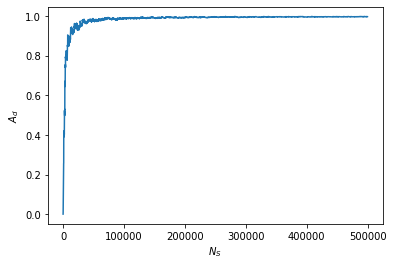

23/06/13 18:22:36 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


Simulation parameters: slope                          1.186144
min_rim_percentage             0.352566
effective_radius_multiplier    1.583192
n_craters_in_study_region      1.000000
z                              0.000000
za                             0.000000
areal_density                  0.000010
Name: 0, dtype: float64


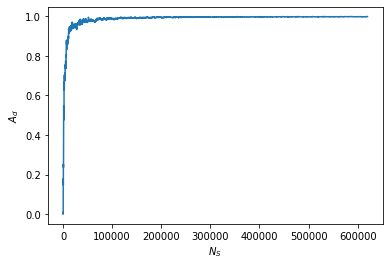

23/06/13 18:22:37 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


Simulation parameters: slope                          1.741412
min_rim_percentage             0.449210
effective_radius_multiplier    1.749021
n_craters_in_study_region      1.000000
z                              0.000000
za                             0.000000
areal_density                  0.000014
Name: 0, dtype: float64


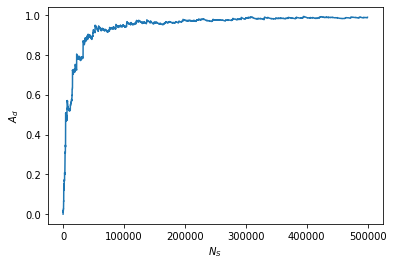

23/06/13 18:22:37 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


Simulation parameters: slope                          2.267193
min_rim_percentage             0.548644
effective_radius_multiplier    1.586159
n_craters_in_study_region      1.000000
z                              0.000000
za                             0.000000
areal_density                  0.000011
Name: 0, dtype: float64


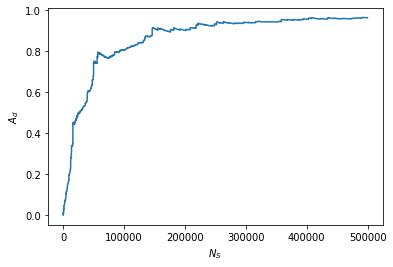

23/06/13 18:22:37 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


Simulation parameters: slope                          2.808754
min_rim_percentage             0.550884
effective_radius_multiplier    1.751545
n_craters_in_study_region      1.000000
z                              0.000000
za                             0.000000
areal_density                  0.000003
Name: 0, dtype: float64


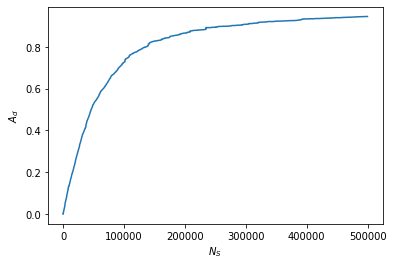

23/06/13 18:22:38 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


In [40]:
for x in range(0,5):
    plot_sim_ci(model, holdout_dfs[x], metric, assembler, ivs, assembler.getInputCols())

In [ ]:
# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns), sample_cadence=1)
pred_df["outside_range"] = pred_df.actual < pred_df.prediction
pred_df.outside_range.mean()

In [ ]:
resid = pred_df["actual"] - pred_df["prediction"]
plt.scatter(pred_df["actual"], resid)
plt.xlabel("$A_d$")
plt.ylabel("Residual")
plt.show()

for iv in assembler.getInputCols():
    if iv in pred_df.columns:
        plt.scatter(pred_df[iv], resid)
        plt.xlabel(iv)
        plt.ylabel("Residual")
        plt.show()

In [ ]:
# Metrics for all test data
all_holdout = pd.concat([x.iloc[-50000:] for x in holdout_dfs])
pred_df = score_model(model, all_holdout, metric, assembler, ivs, list(X_train.columns), sample_cadence=1)
pred_df["outside_range"] = pred_df.actual < pred_df.prediction
pred_df.outside_range.mean()

In [ ]:
resid = pred_df["actual"] - pred_df["prediction"]
plt.scatter(pred_df["actual"], resid)
plt.xlabel("$A_d$")
plt.ylabel("Residual")
plt.show()

for iv in assembler.getInputCols():
    if iv in pred_df.columns:
        plt.scatter(pred_df[iv], resid)
        plt.xlabel(iv)
        plt.ylabel("Residual")
        plt.show()